
📂 Fold 1/5


 51%|█████     | 507/1000 [06:22<06:12,  1.32it/s]

Early stopping at epoch 508
✅ Fold 1 — Best Epoch: 438 | MSE: 0.0698 | MAPE: 0.1490


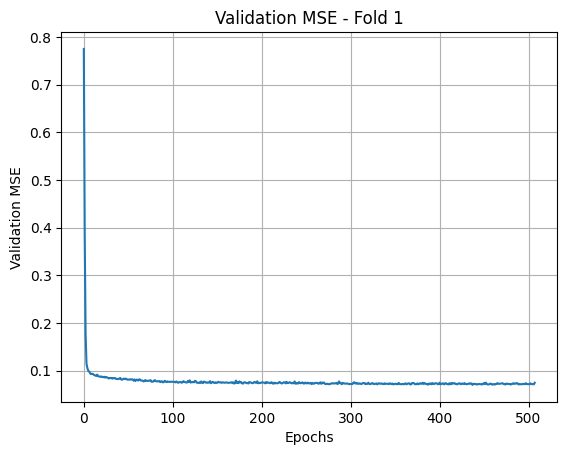


📂 Fold 2/5


 36%|███▌      | 356/1000 [04:29<08:06,  1.32it/s]

Early stopping at epoch 357
✅ Fold 2 — Best Epoch: 287 | MSE: 0.0750 | MAPE: 0.1501


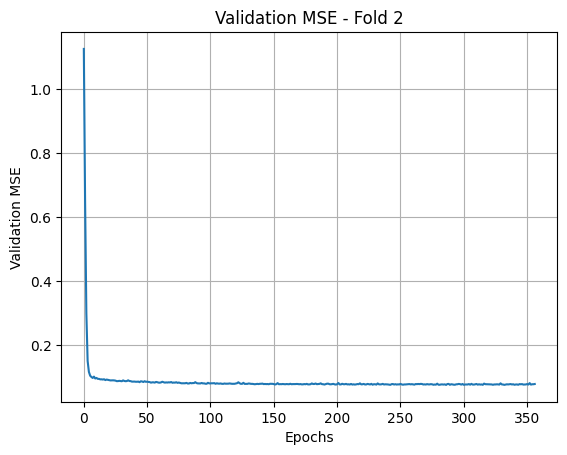


📂 Fold 3/5


 32%|███▏      | 322/1000 [04:03<08:33,  1.32it/s]

Early stopping at epoch 323
✅ Fold 3 — Best Epoch: 253 | MSE: 0.0773 | MAPE: 0.1550


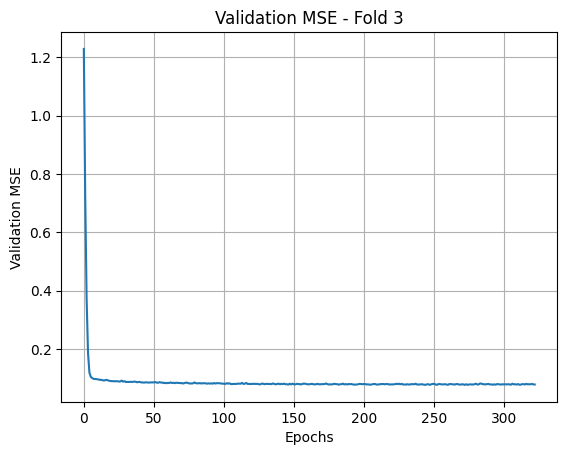


📂 Fold 4/5


 39%|███▊      | 387/1000 [04:52<07:43,  1.32it/s]

Early stopping at epoch 388
✅ Fold 4 — Best Epoch: 318 | MSE: 0.0781 | MAPE: 0.1540


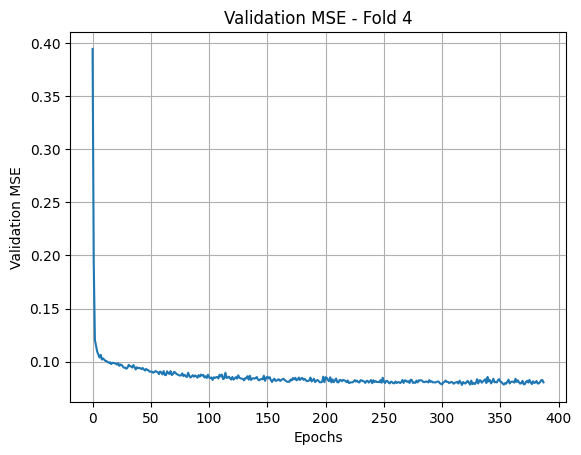


📂 Fold 5/5


 30%|███       | 303/1000 [03:50<08:50,  1.31it/s]

Early stopping at epoch 304
✅ Fold 5 — Best Epoch: 234 | MSE: 0.0727 | MAPE: 0.1524


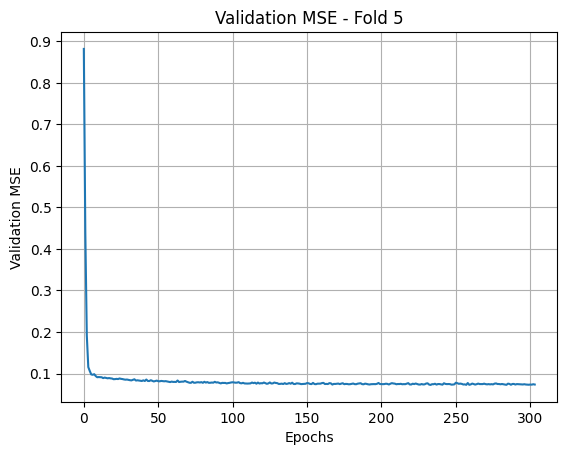


🏁 Overall Cross-Validation Results:
Best Fold: 1
✅ Best MSE: 0.0698
✅ Best MAPE: 0.1490
📊 Avg MSE: 0.0746
📊 Avg MAPE: 0.1521
🏠 RMSE (in dollars): $27,308


In [ ]:
# Install dependencies
#!pip install torchmetrics

# Imports
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler,QuantileTransformer
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanAbsolutePercentageError
import tqdm
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 64

dataset = pd.DataFrame(fetch_california_housing().data, columns=fetch_california_housing().feature_names)
target = fetch_california_housing().target
dataset['Pop_density'] = dataset['Population'] / (dataset['AveOccup'] + 1e-5)
dataset['Lat_Long'] = dataset['Latitude'] * dataset['Longitude']
dataset['Rooms_per_person'] = dataset['AveRooms'] / (dataset['Population'] + 1e-5)

lower_bound = np.percentile(target, 10)
upper_bound = np.percentile(target, 90)

# Create a mask for filtering
mask = (target >= lower_bound) & (target <= upper_bound)

# Apply mask to data and target
X = dataset.loc[mask].copy()
X['Population'] = np.log1p(X['Population'])
X['MedInc'] = np.log1p(X['MedInc'])
y = target[mask]

X = X.values
kf = KFold(n_splits=5, shuffle=True, random_state=123)

best_overall_mse = float('inf')
best_overall_mape = None
best_fold = None

mse_scores = []
mape_scores = []

def robust_mape(y_pred, y_true, epsilon=0.5):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon)))

def weighted_mape(y_pred, y_true, epsilon=0.1):
    weights = y_true / (y_true + epsilon)  # Smaller y -> smaller weight
    return torch.mean(weights * torch.abs((y_true - y_pred) / (y_true + epsilon)))


EPOCHS = 1000
for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\n📂 Fold {fold+1}/5")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    scaler = QuantileTransformer(output_distribution='normal')
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

    #y_train = torch.log1p(y_train)
    #y_test = torch.log1p(y_test)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Define model for this fold
    model = nn.Sequential(
        nn.Linear(11, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.Tanh(),
        nn.Linear(100, 50),
        nn.BatchNorm1d(50),
        nn.ReLU(),
        nn.Linear(50, 1)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.SmoothL1Loss()
    mape = MeanAbsolutePercentageError()

    loss_list = np.zeros((EPOCHS,))
    mse_list = np.zeros((EPOCHS,))
    mape_list = np.zeros((EPOCHS,))

    best_val_loss = float('inf')
    patience = 70
    min_delta = 1e-5
    patience_counter = 0

    for epoch in tqdm.trange(EPOCHS):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            y_pred = model(xb)
            mse_loss = loss_fn(y_pred, yb)  # SmoothL1Loss
            mape_loss = robust_mape(y_pred, yb)  # Robust MAPE
            loss = 0.7 * mse_loss + 0.3 * mape_loss

            #loss = loss_fn(y_pred, yb)
            epoch_loss += loss.item() * xb.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_list[epoch] = epoch_loss / len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_test)
            #y_pred_val = torch.expm1(model(X_test))
            val_loss = loss_fn(y_pred_val, y_test).item()
            mse_list[epoch] = val_loss
            mape_list[epoch] = mape(y_pred_val, y_test).item()

        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(best_model_state)

    best_epoch = np.argmin(mse_list[:epoch+1])
    best_mse = mse_list[best_epoch]
    best_mape = mape_list[best_epoch]

    print(f"✅ Fold {fold+1} — Best Epoch: {best_epoch+1} | MSE: {best_mse:.4f} | MAPE: {best_mape:.4f}")
    if best_mse < best_overall_mse:
        best_overall_mse = best_mse
        best_overall_mape = best_mape
        best_fold = fold + 1

    mse_scores.append(best_mse)
    mape_scores.append(best_mape)

    plt.plot(mse_list[:epoch+1])
    plt.title(f"Validation MSE - Fold {fold+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Validation MSE")
    plt.grid(True)
    plt.show()

avg_mse = np.mean(mse_scores)
avg_mape = np.mean(mape_scores)

print("\n🏁 Overall Cross-Validation Results:")
print(f"Best Fold: {best_fold}")
print(f"✅ Best MSE: {best_overall_mse:.4f}")
print(f"✅ Best MAPE: {best_overall_mape:.4f}")
print(f"📊 Avg MSE: {avg_mse:.4f}")
print(f"📊 Avg MAPE: {avg_mape:.4f}")
rmse_in_100k = np.sqrt(avg_mse)  # root mean squared error in 100k units
rmse_in_dollars = rmse_in_100k * 100_000

print(f"🏠 RMSE (in dollars): ${rmse_in_dollars:,.0f}")

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import tqdm

# --- Load & Preprocess Data ---
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target * 100_000


# Apply mask to filter X and y
#X = X[mask].reset_index(drop=True)
#y = y[mask]
# Apply mask to data and target

# Feature engineering
X['Pop_density'] = X['Population'] / (X['AveOccup'] + 1e-5)
X['Lat_Long'] = X['Latitude'] * X['Longitude']
X['Rooms_per_person'] = X['AveRooms'] / (X['Population'] + 1e-5)
X['Population'] = np.log1p(X['Population'])
X['MedInc'] = np.log1p(X['MedInc'])

# Define thresholds
threshold = 250_000


# Train/test split (shared for all models)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

lower_bound = np.percentile(y_train, 10)
upper_bound = np.percentile(y_train, 90)

# Create a mask for filtering
mask = (y_train >= lower_bound) & (y_train <= upper_bound)

X_train = X_train[mask].reset_index(drop=True)
y_train = y_train[mask]
low_mask = y_train <= threshold
high_mask = y_train > threshold

# Split into 2 sets
X_low = X_train[low_mask]
y_low = y_train[low_mask]
X_high = X_train[high_mask]
y_high = y_train[high_mask]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_low = scaler.transform(X_low)
X_high = scaler.transform(X_high)

# Convert to tensors
def to_tensor(x, y):
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train_t, y_train_t = to_tensor(X_train_scaled, y_train)
X_test_t, y_test_t = to_tensor(X_test_scaled, y_test)
X_low_t, y_low_t = to_tensor(X_low, y_low)
X_high_t, y_high_t = to_tensor(X_high, y_high)

# DataLoaders
BATCH_SIZE = 128
low_loader = DataLoader(TensorDataset(X_low_t, y_low_t), batch_size=BATCH_SIZE, shuffle=True)
high_loader = DataLoader(TensorDataset(X_high_t, y_high_t), batch_size=BATCH_SIZE, shuffle=True)
y_class = (y_train > threshold).astype(np.float32).reshape(-1, 1)
full_loader = DataLoader(TensorDataset(X_train_t, torch.tensor(y_class)), batch_size=BATCH_SIZE, shuffle=True)


# --- Define Models ---
def make_regressor(input_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

def make_classifier(input_dim):
    return nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.2),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )

input_dim = X.shape[1]  # 11 features after engineering

model_low = make_regressor(input_dim)
model_high = make_regressor(input_dim)
classifier = make_classifier(input_dim)

# --- Training Utility ---
def train_model(model, train_loader, val_loader=None, epochs=100, task='regression', patience=10):
    model.train()
    criterion = nn.BCELoss() if task == 'classification' else nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in tqdm.trange(epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            if task == 'classification':
                yb = yb.view(-1, 1).float()
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation step
        if val_loader is not None:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for xb, yb in val_loader:
                    pred = model(xb)
                    if task == 'classification':
                        yb = yb.view(-1, 1).float()
                    val_loss = criterion(pred, yb)
                    val_losses.append(val_loss.item())
            avg_val_loss = np.mean(val_losses)

            # Check if improved
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict()
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
X_low_train, X_low_val, y_low_train, y_low_val = train_test_split(X_low, y_low, test_size=0.2, random_state=123)
X_high_train, X_high_val, y_high_train, y_high_val = train_test_split(X_high, y_high, test_size=0.2, random_state=123)
X_train_train, X_train_val, y_class_train, y_class_val = train_test_split(X_train_scaled, y_class, test_size=0.2, random_state=123)

# --- Train models ---
print("Training Model A (low prices)")
train_model(model_low, low_loader, epochs=500)

print("Training Model B (high prices)")
train_model(model_high, high_loader, epochs=500)

print("Training Classifier")
train_model(classifier, full_loader, epochs=500, task='classification')

# --- Hybrid Inference ---
model_low.eval()
model_high.eval()
classifier.eval()

with torch.no_grad():
    preds = []
    truths = []

    for x, y_true in zip(X_test_t, y_test_t):
        x = x.unsqueeze(0)
        pred_class = classifier(x)
        if pred_class.item() < 0.5:
            y_pred = model_low(x)
        else:
            y_pred = model_high(x)
        preds.append(y_pred.item())
        truths.append(y_true.item())

# --- Evaluation ---

mse = mean_squared_error(truths, preds)
mape = mean_absolute_percentage_error(truths, preds)

print(f"\n📈 Hybrid Model Results:")
print(f"✅ MSE: {mse:.4f}")
print(f"✅ MAPE: {mape:.4f}")
print(f"✅ RMSE (in dollars): ${np.sqrt(mse):,.2f}")


20640 20640
Training Model A (low prices)


100%|██████████| 500/500 [01:33<00:00,  5.34it/s]


Training Model B (high prices)


100%|██████████| 500/500 [00:27<00:00, 18.00it/s]


Training Classifier


 63%|██████▎   | 314/500 [01:52<00:57,  3.26it/s]

In [38]:
errors = torch.abs((y_pred_val - y_test) / (y_test + 1e-8)).numpy()
plt.scatter(y_test.numpy(), errors)
plt.xlabel("True Value ($100k)")
plt.ylabel("Percentage Error")
plt.title("MAPE by House Value")
plt.grid(True)


NameError: name 'y_pred_val' is not defined

# VAL

MSE: 0.0729 | MAPE: 0.1481

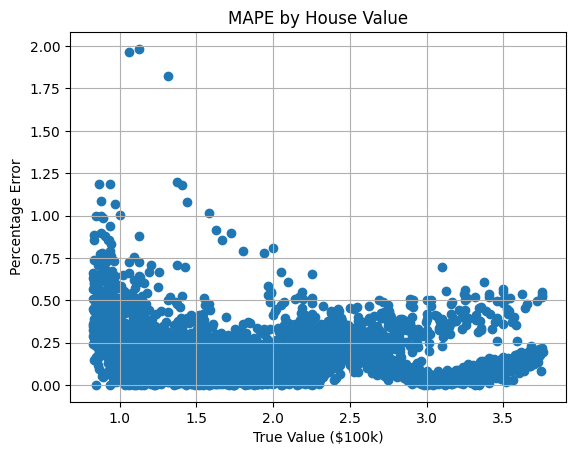

In [11]:
import matplotlib.pyplot as plt

model_low.eval()
model_high.eval()
classifier.eval()

errors = []
true_vals = []

with torch.no_grad():
    for x, y_true in zip(X_test_t, y_test_t):
        x = x.unsqueeze(0)
        pred_class = classifier(x)
        if pred_class.item() < 0.5:
            y_pred = model_low(x)
        else:
            y_pred = model_high(x)
        error = torch.abs((y_pred - y_true) / (y_true + 1e-8))
        errors.append(error.item())
        true_vals.append(y_true.item())

errors = np.array(errors)
true_vals = np.array(true_vals)

plt.scatter(true_vals / 100_000, errors)  # scaling back to original $100k units
plt.xlabel("True Value ($100k)")
plt.ylabel("Percentage Error")
plt.title("MAPE by House Value")
plt.grid(True)
plt.show()


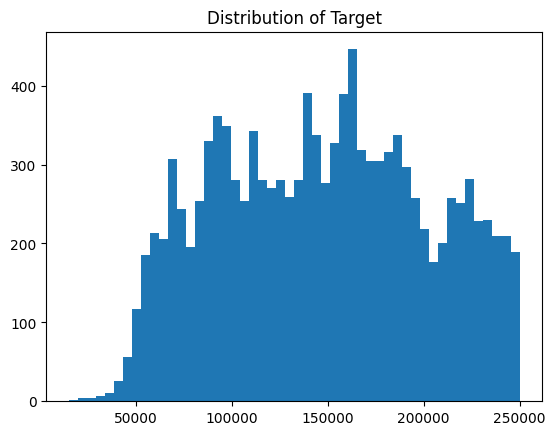

In [6]:
import matplotlib.pyplot as plt
plt.hist(y_low, bins=50)
plt.title("Distribution of Target")
plt.show()